## Churn Prediction

Problem Statement: Can we predict customer churn based on features like life time value most recent order date etc

I did some research on customer churn and came across two topics that deal with contractural and non contractual data. Meaning, Dispatch customers are not in a contractural setting ( I dont think so) if they were I would utilize the Kaplan Meier model because it works best with contractural data. (Because the customers are in contract I can easily tell when they churn without calculating). However, I would have to use the derivative of the Pareto/NBD Model called BG/NBD model that focuses on non contractural customer setting. From my understanding the model needs only 3 factors. Frequency Recency and Monetary

-The number of transactions a customer has made after their first transaction. -The time of a customer's last purchase. -How long the customer been tracked for.

The BG/NBD model quantifies the lifetime value of a customer by assessing the expected number of transactions the customer will have in the future as long as they has not churned. There are two options avaliable for the customer. First the customer purchases or does not purchase again, and Second the customer churns or does not churn. These two options are probabilisitic, meaning that there is a probability associated with the customer pruchasing at a given period and a different probability of a customer churning after a purchase.

The model assumes the following:

Until a customer churns, the number of transactions made by a customer follows a Poisson process - a simple and widely used stochastic process for modeling the times at which arrivals enter a system.

So at every period (week) in a defined time interval (one year = 52 weeks), the customer decides whether to pruchase or not. The number of purchases a customer makes is dependent on each customer's probability distribution around lambda, the arrival rate.

Goals:

LTV = expected number of transactions * revenue per transactions * margin

BG/NBD model: predict 1) expected number of transactions; 2) probability of being alive
Gamma-Gamma model: predict expected monetary value per transaction
Margin is defined by business, e.g., discount, campaign, something relates to the price

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lifetimes
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',500)
pd.set_option('max_colwidth', None)

In [3]:
df = pd.read_csv("Churn_V3.csv")
df.columns = [c.replace(' ', '_') for c in df.columns]
df.columns = [c.replace('.', '_') for c in df.columns]
df.head()

,orders_organization_id,orders_revenue_received_at_date,final_price_calculations_final_order_price,orders_market_name,orders_delivered_order_count
0,17326,2023-04-12,0.00,Philadelphia,0
1,13361,2023-04-12,36.93,Miami,1
2,8330,2023-04-12,93.16,Seattle,1
3,2000,2023-04-12,0.00,Dallas,0
4,44526,2023-04-12,198.08,Washington D.C.,1


In [4]:
df.dtypes

orders_organization_id                          int64
orders_revenue_received_at_date                object
final_price_calculations_final_order_price    float64
orders_market_name                             object
orders_delivered_order_count                    int64
dtype: object

In [5]:
#df['Final_Price_Calculations_Final_Order_Price'] = df['Final_Price_Calculations_Final_Order_Price'].str.replace(',', '')
#df['Final_Price_Calculations_Final_Order_Price'] = df['Final_Price_Calculations_Final_Order_Price'].str.replace('$', '')
#df['Final_Price_Calculations_Final_Order_Price'] = df['Final_Price_Calculations_Final_Order_Price'].astype(float)

data_types_dict = {'orders_organization_id': object}
df = df.astype(data_types_dict)

df.dtypes


orders_organization_id                         object
orders_revenue_received_at_date                object
final_price_calculations_final_order_price    float64
orders_market_name                             object
orders_delivered_order_count                    int64
dtype: object

In [6]:
df['amt'] = df['orders_delivered_order_count'] * df['final_price_calculations_final_order_price']

def clean_date(date):
    date = pd.to_datetime(date)
    return date

df["orders_revenue_received_at_date"] = clean_date(df["orders_revenue_received_at_date"])

df.dtypes

print(df['orders_revenue_received_at_date'].min())
print(df['orders_revenue_received_at_date'].max())

2022-01-01 00:00:00
2023-04-12 00:00:00


In [7]:
# Cheking percent of missing values in columns
df_missing_columns = (round(((df.isnull().sum()/len(df.index))*100),2).to_frame('null')).sort_values('null', ascending=False)
df_missing_columns

,null
orders_organization_id,0.0
orders_revenue_received_at_date,0.0
final_price_calculations_final_order_price,0.0
orders_market_name,0.0
orders_delivered_order_count,0.0
amt,0.0


### Feature aggregation

In [8]:
from lifetimes.plotting import *
from lifetimes.utils import *

modeldata = summary_data_from_transaction_data(df, 'orders_organization_id', 'orders_revenue_received_at_date', 
                                               monetary_value_col='amt', 
                                               observation_period_end='2023-04-12')
modeldata.head()
modeldata.shape
modeldata = modeldata[modeldata['frequency']<modeldata['T']]
modeldata.shape

(6081, 4)

count    6081.000000
mean       21.112975
std        47.159485
min         0.000000
25%         0.000000
50%         3.000000
75%        16.000000
max       462.000000
Name: frequency, dtype: float64
0.31261305706298304


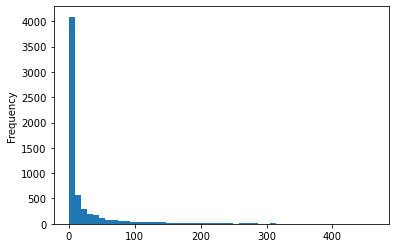

In [9]:
modeldata['frequency'].plot(kind='hist', bins=50)
print(modeldata['frequency'].describe())
# frequency=0 means no repeated purchase. 31.2% customers left after one purchase.
print(sum(modeldata['frequency'] == 0)/float(len(modeldata)))

In [10]:
from lifetimes import BetaGeoFitter

# penalizer_coef: regularization, to prevent overfitting especially when the dataset is small, can set 0 when dataset is large enough
bgf = BetaGeoFitter(penalizer_coef=0.0)

# fit BG model on the whole data
bgf.fit(modeldata['frequency'], modeldata['recency'], modeldata['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 6081 subjects, a: 0.19, alpha: 3.63, b: 2.16, r: 0.30>


<AxesSubplot:title={'center':'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

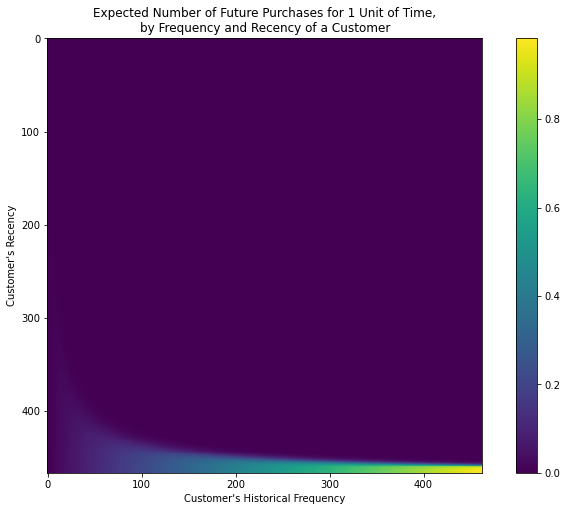

In [11]:
from lifetimes.plotting import plot_frequency_recency_matrix

fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf)

Target: expected number of purchase in next 1 day
X-axis: frequency
Y-axis: recency

Up-right: dark, rare chance of purchase, people have high frequency, but rarely buy things recently, they might quit the product/your business
Diagonal: blue/green curve, relatively good customer
Recency is more important than frequency. People with good recency (bottom) is more likely to buy than people with high frequency but bad recency (up right).

<AxesSubplot:title={'center':'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

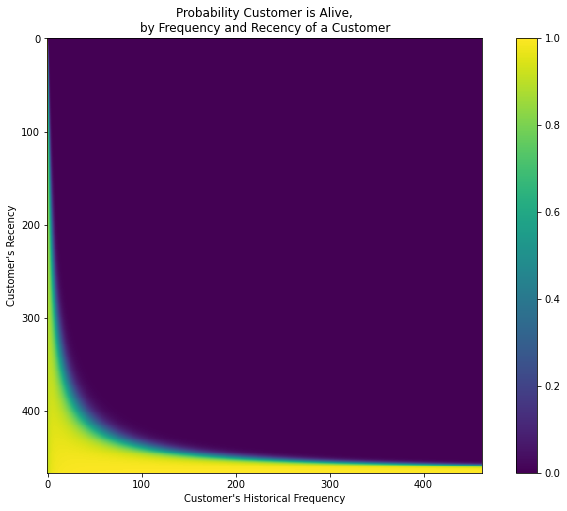

In [12]:
from lifetimes.plotting import plot_probability_alive_matrix

fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)

Corner Right : abyss

Bottom-left: high activity. Active probability decrease exponentially with recency (time between first and last purchase) decrease.

Predict next day

In [13]:
t = 1  # in the next 1 day
modeldata['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, modeldata['frequency'], modeldata['recency'], modeldata['T'])


In [14]:
# Highest 5 customers
modeldata.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,monetary_value,predicted_purchases
orders_organization_id,,,,,
11441,390.0,463.0,463.0,2040.994718,0.835833
16611,405.0,461.0,462.0,210.653975,0.869266
605,422.0,466.0,466.0,1889.037962,0.898619
45477,150.0,157.0,157.0,38.455800,0.933926
19990,462.0,466.0,466.0,19149.123009,0.983775


In [15]:
# Lowest 5 customers
modeldata.sort_values(by='predicted_purchases').head(5)

,frequency,recency,T,monetary_value,predicted_purchases
orders_organization_id,,,,,
17636,52.0,74.0,464.0,104.519615,5.099406e-40
2038,81.0,157.0,463.0,134.294198,1.665928e-36
1583,114.0,217.0,463.0,134.894474,9.703026e-36
21417,61.0,116.0,464.0,74.343770,2.176044e-35
14606,39.0,57.0,464.0,317.145897,2.408137e-34


<AxesSubplot:title={'center':'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

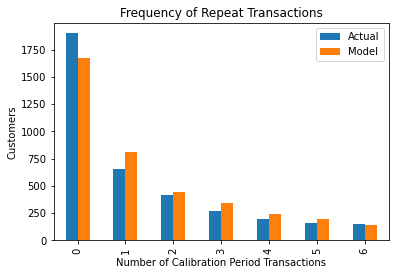

In [16]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

Error: gap between two bars

The model is decent because:

somewhat accurate: Gaps between two bars are small
somewhat stable: Two bars decline consistently. Except for periods 5 and 6 it seems it stays stagnant
If the pattern (two bars) is not declining consistently, the model is not stable.

There are both positive and negative errors, the error is random.
If the model prediction is always larger/smaller than actual, the model is not good because the error is not random, there’s still room for the model to be improved.

In [17]:
summary_cal_holdout = calibration_and_holdout_data(df, 'orders_organization_id', 'orders_revenue_received_at_date',
                                        calibration_period_end='2022-12-10',
                                        observation_period_end='2023-04-10' )
summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
orders_organization_id,,,,,
3,242.0,340.0,341.0,81.0,121.0
6,6.0,252.0,330.0,0.0,121.0
7,46.0,318.0,323.0,5.0,121.0
12,7.0,273.0,296.0,1.0,121.0
13,1.0,34.0,45.0,1.0,121.0


<AxesSubplot:title={'center':'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

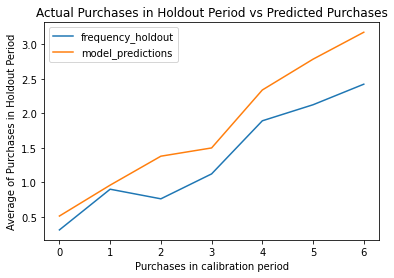

In [18]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

bgf2 = BetaGeoFitter(penalizer_coef=0.0)
bgf2.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf2, summary_cal_holdout)

The model is good because model prediction (orange line) and true data (blue line) dont overlap.

In [19]:
summary_cal_holdout['predicted_purchases'] = bgf2.conditional_expected_number_of_purchases_up_to_time(100, summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
summary_cal_holdout

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout,predicted_purchases
orders_organization_id,,,,,,
3,242.0,340.0,341.0,81.0,121.0,68.731284
6,6.0,252.0,330.0,0.0,121.0,1.660938
7,46.0,318.0,323.0,5.0,121.0,13.777819
12,7.0,273.0,296.0,1.0,121.0,2.312165
13,1.0,34.0,45.0,1.0,121.0,2.284396
...,...,...,...,...,...,...
48384,0.0,0.0,1.0,0.0,121.0,5.341827
48400,0.0,0.0,1.0,0.0,121.0,5.341827
48409,0.0,0.0,1.0,0.0,121.0,5.341827


In [20]:
from sklearn.metrics import mean_squared_error, r2_score

def smape(y_true, y_pred):
    difference = abs(y_true - y_pred)
    denominator = (abs(y_true) + abs(y_pred))/2
    return np.mean(np.where(denominator==0, 0, difference/denominator))

In [21]:
print('RMSE: ', mean_squared_error(summary_cal_holdout['frequency_holdout'], summary_cal_holdout['predicted_purchases'])**(1/2))
print('SMAPE', smape(summary_cal_holdout['frequency_holdout'], summary_cal_holdout['predicted_purchases']))
print('R2: ', r2_score(summary_cal_holdout['frequency_holdout'], summary_cal_holdout['predicted_purchases']))

RMSE:  6.6206046371331615
SMAPE 1.4509260596976334
R2:  0.7702079028726386


In [22]:
# predict for a specific organization, number of purchase in next 10 days
t = 10
individual = modeldata.loc[26]
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

0.06095405705704279

Probability of staying alive example


<AxesSubplot:title={'center':'History of P_alive'}, ylabel='P_alive'>

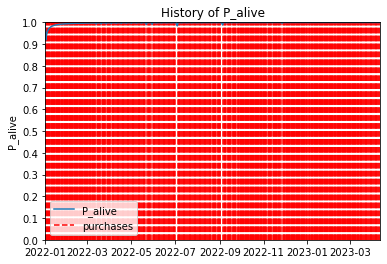

In [23]:
# Customer 48428
# frequent customer, alive throughout the year.
id = 605
days_since_birth = 365
sp_trans = df.loc[df['orders_organization_id'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'orders_revenue_received_at_date')

<AxesSubplot:title={'center':'History of P_alive'}, ylabel='P_alive'>

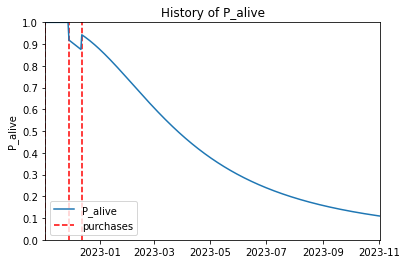

In [24]:
# Customer 26
# frequent customer, alive throughout the year.
id = 26
days_since_birth = 365
sp_trans = df.loc[df['orders_organization_id'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'orders_revenue_received_at_date')

Gamma Gamma Model

The Monetary Model predicts monetary value per transaction
Focus on customers with repurchase behavior
Focus on estimating the customers who had at least one repeat purchase. Because customer with only one purchase is very less likely to make additional purchase. It’s difficult to save/wake up these silent customers.

In [25]:
returning_customers_summary = modeldata[modeldata['frequency']>0]

# 69% customer left
len(returning_customers_summary)/len(modeldata)

0.687386942937017

In [26]:
returning_customers_summary.shape
returning_customers_summary1 = returning_customers_summary.loc[returning_customers_summary["monetary_value"] > 0 ]
returning_customers_summary1

,frequency,recency,T,monetary_value,predicted_purchases
orders_organization_id,,,,,
3,325.0,464.0,464.0,687.201292,0.695077
6,6.0,252.0,453.0,51.701667,0.006787
7,52.0,445.0,446.0,79.318077,0.115819
12,8.0,364.0,419.0,50.263750,0.018407
13,2.0,135.0,168.0,114.500000,0.012177
...,...,...,...,...,...
53058,4.0,6.0,6.0,47.730000,0.426749
53066,4.0,12.0,12.0,46.420000,0.263756
53118,6.0,9.0,9.0,258.211667,0.482412


## Predicting Monetary Value per Organization

In [27]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary1['frequency'],
        returning_customers_summary1['monetary_value'], q_constraint=True)

print(ggf)

<lifetimes.GammaGammaFitter: fitted with 4053 subjects, p: 2.35, q: 2.25, v: 75.43>


In [28]:
ggf.conditional_expected_average_profit(modeldata['frequency'], \
    modeldata['monetary_value']).head(10)

orders_organization_id
3     686.311356
6      59.044728
7      79.951727
12     55.974931
13    120.265002
14    141.965140
18    124.316236
26     63.859942
43     66.901303
51     77.207750
dtype: float64

In [29]:
ggf.conditional_expected_average_profit(modeldata['frequency'], \
    modeldata['monetary_value']).tail(10)

orders_organization_id
53268    141.96514
53269    141.96514
53322    141.96514
53325    141.96514
53331    141.96514
53340    141.96514
53357    141.96514
53358    141.96514
53362    141.96514
53363    141.96514
dtype: float64

In [30]:
#CLV model
clv = ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    returning_customers_summary1['frequency'],
    returning_customers_summary1['recency'],
    returning_customers_summary1['T'],
    returning_customers_summary1['monetary_value'],
    time=4, # months
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
)

returning_customers_summary1['clv'] = clv

#Print the top 10 most valued customers
returning_customers_summary1.sort_values('clv', ascending=False).head(10)
returning_customers_summary1.reset_index()

,orders_organization_id,frequency,recency,T,monetary_value,predicted_purchases,clv
0,3,325.0,464.0,464.0,687.201292,0.695077,54615.877901
1,6,6.0,252.0,453.0,51.701667,0.006787,45.978288
2,7,52.0,445.0,446.0,79.318077,0.115819,1059.663176
3,12,8.0,364.0,419.0,50.263750,0.018407,117.968230
4,13,2.0,135.0,168.0,114.500000,0.012177,164.332718
...,...,...,...,...,...,...,...
4048,53058,4.0,6.0,6.0,47.730000,0.426749,2174.402075
4049,53066,4.0,12.0,12.0,46.420000,0.263756,1401.594273
4050,53118,6.0,9.0,9.0,258.211667,0.482412,10703.490587
4051,53137,3.0,8.0,8.0,70.490000,0.269269,1955.236624


Disadvantages of Probabilistic Model

Only use transaction features. No capability to add other important features like age, gender, education, price, trading behaviors.

Not accurate. The model is built on strong assumptions, which might not be accurate in practical application. True data often doesn’t follow the distribution

## Machine Learning Section

Run both xgboost and Lightgbm algorithims and compare it to bg/ngb model

In [31]:
import datetime

df["orders_revenue_received_at_date"] = pd.to_datetime(df["orders_revenue_received_at_date"]).dt.date

df_train = df[df.orders_revenue_received_at_date <= datetime.date(2023, 1, 1)]
df_test = df[df.orders_revenue_received_at_date > datetime.date(2023, 1, 1)]

maxdate = df_train.orders_revenue_received_at_date.max()
mindate = df_train.orders_revenue_received_at_date.min()

df_train['duration'] =  (maxdate - df_train.orders_revenue_received_at_date)/np.timedelta64(1, 'D')
# get time duration between the last transaction to now
dfsum1 = df_train.groupby(['orders_organization_id'])['duration'].min().reset_index()
dfsum1.rename(columns = {'duration':'latetime'}, inplace = True)

# get time duration between the first transaction to now
dfsum2 = df_train.groupby(['orders_organization_id'])['duration'].max().reset_index()
dfsum2.rename(columns = {'duration':'earlytime'}, inplace = True)

# get transaction frequency (whole history)
dfsum3 = df_train.groupby(['orders_organization_id'])['orders_revenue_received_at_date'].nunique().reset_index()
dfsum3.rename(columns={'orders_revenue_received_at_date': 'freq'}, inplace=True)
# get transaction frequency (recent 3 months history)
dfsum4 = df_train[df_train.duration<91].groupby(['orders_organization_id'])['orders_revenue_received_at_date'].nunique().reset_index()
dfsum4.rename(columns={'orders_revenue_received_at_date': 'freq_3m'}, inplace=True)

dfsum = pd.merge(dfsum1, dfsum2, on=['orders_organization_id'], how='outer')
dfsum = pd.merge(dfsum, dfsum3, on=['orders_organization_id'], how='outer')
dfsum = pd.merge(dfsum, dfsum4, on=['orders_organization_id'], how='outer')

# get target: number of transactions in test set
dfsum_target = df_test.groupby(['orders_organization_id'])['orders_revenue_received_at_date'].nunique().reset_index()
dfsum_target.rename(columns={'orders_revenue_received_at_date': 'target'}, inplace=True)
dfsum = pd.merge(dfsum, dfsum_target, on=['orders_organization_id'], how='left')
dfsum  = dfsum.fillna(0).sort_values(['target'], ascending = False)

In [50]:
dfsum.head(10)
#dfsum.shape

,orders_organization_id,latetime,earlytime,freq,freq_3m,target
2751,19990,0.0,365.0,363,89.0,100.0
5314,45477,0.0,56.0,53,53.0,98.0
115,605,0.0,365.0,327,87.0,96.0
2278,16611,1.0,361.0,319,76.0,87.0
2396,17326,1.0,354.0,271,76.0,87.0
3446,24653,1.0,355.0,237,75.0,87.0
2460,17784,1.0,363.0,284,75.0,86.0
1709,11441,1.0,362.0,306,77.0,85.0
2227,16279,2.0,362.0,212,70.0,84.0
3259,23574,1.0,314.0,205,76.0,79.0


In [69]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


xgb_model = xgb.XGBRegressor(n_estimators=5539, objective='reg:linear', max_depth = 2, min_child_weight = 1, subsample = 0.75, learning_rate = 0.1, colsample_bytree = 0.75)
 
predictors = ['latetime','earlytime', 'freq','freq_3m']
X = dfsum[predictors]
y = dfsum.target

x_trains, x_valids, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=0)

xgb_model.fit(x_trains, y_train)

[22:41:17] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.75,
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=5539, n_jobs=16,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=0.75, tree_method='exact', validate_parameters=1,
             verbosity=None)

Model is not over fitted based on colsample_bytree=1 (lower ratio means no overfitting). Subsample  = 1 same as colsample_by tree lower ratio means no overfitting. Note there might be data leakage so must conduct cross validation n fold =10 and forward facing

In [70]:
y_pred = xgb_model.predict(x_valids)
rmse = mean_squared_error(y_valid, y_pred)**(1/2)
print('RMSE on test set: ', rmse)

RMSE on test set:  6.019159764301778


In [71]:
xgb_model2 = xgb.XGBRegressor(n_estimators=2297, objective='reg:linear', max_depth = 3)
xgb_model2.fit(X, y)
y_pred2 = xgb_model2.predict(X)
print('RMSE: ', mean_squared_error(y, y_pred2)**(1/2)) 
print('SMAPE', smape(y, y_pred2))
print('R2: ', r2_score(y, y_pred2))

[22:41:58] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
RMSE:  1.342855283969025
SMAPE 1.3837696086379394
R2:  0.987264144384022


RMSE is the standard deviation of the residuals (prediction errors). Residuals are a measure of how far from the regression line data points are; RMSE is a measure of how spread out these residuals are. Smaller the RMSE the better


SMAPE is an accuracy measure based on percentage (or relative) errors .For example, a value of 2% means there is relatively little difference between your forecast methods and the real data you have gaine

 R2 Squared tells how well the predictor variables can explain the variation in the response variable
 
 However, there is likely be data leakage within this model so the model has to be hyperparameter tuned 

In [67]:
#Data leakage
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# create a dictionary containing the hyperparameters
# to tune and the range of values to try
parameters = {"subsample":[0.75, 1],
              "colsample_bytree":[0.75, 1],
              "max_depth":[2, 6],
              "n_estimators":[50,5000],
              "min_child_weight":[1, 5],
              "learning_rate":[0.1, 0.01]}

# create a validation set which will be used for early stopping
eval_set = [(x_valids, y_valid)]
estimator = xgb.XGBClassifier(n_estimators=5593, 
                               n_jobs=-1, 
                               eval_metric='logloss',
                               early_stopping_rounds=10)
model = GridSearchCV(estimator=estimator,
                      param_grid=parameters,                      
                      cv=3,
                      scoring="neg_log_loss")

model.fit(x_trains,y_train)

print(model.best_params_)

[23:18:22] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:18:24] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:18:26] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some p

[09:43:42] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[09:48:17] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[09:48:22] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some p

[10:28:21] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:29:49] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:31:28] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some p

[10:55:22] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:57:02] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:58:46] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some p

[11:26:24] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:29:05] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:31:25] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some p

[11:47:27] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:49:46] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:51:25] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some p

[12:07:28] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:10:00] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:12:14] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some p

[12:34:09] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:34:10] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:35:42] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some p

[14:17:05] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:17:07] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:17:10] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some p

After tuning the model the best parameters are :

{'colsample_bytree': 0.75, 'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 1, 'subsample': 0.75}


In [72]:
#Re run xgboost

xgb_model3 = xgb.XGBRegressor(n_estimators=50, objective='reg:linear', max_depth = 2, min_child_weight = 1, subsample = 0.75, learning_rate = 0.1, colsample_bytree = 0.75)
xgb_model3.fit(X, y)
y_pred3 = xgb_model3.predict(X)
print('RMSE: ', mean_squared_error(y, y_pred3)**(1/2)) 
print('SMAPE', smape(y, y_pred3))
print('R2: ', r2_score(y, y_pred3))

[22:42:14] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
RMSE:  4.787560132171456
SMAPE 1.4787562296663583
R2:  0.8381181400192756


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

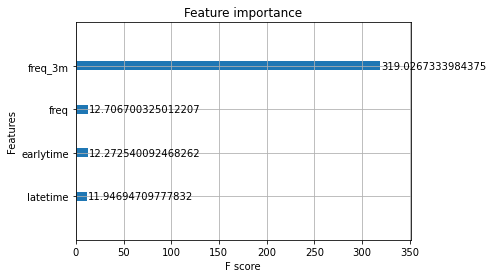

In [43]:
xgb.plot_importance(xgb_model, importance_type='gain')

Feature importance
importance_type:

‘weight’ - the number of times a feature is used to split the data across all trees.

‘gain’ - the average gain across all splits the feature is used in. most popular way.

‘cover’ - the average coverage across all splits the feature is used in. (yes/no proportion)

‘total_gain’ - the total gain across all splits the feature is used in.

‘total_cover’ - the total coverage across all splits the feature is used in.

The Gain is the most relevant attribute to interpret the relative importance of each feature.


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

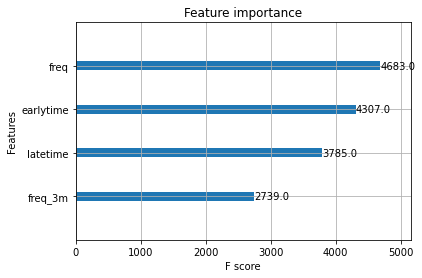

In [45]:
xgb.plot_importance(xgb_model, importance_type='weight')

In [73]:
y_pred3

array([88.953804  , 69.935005  , 88.953804  , ...,  1.025696  ,
        0.42217046,  6.450511  ], dtype=float32)

In [47]:
dfsum['y_pred2'] = y_pred2
dfsum

,orders_organization_id,latetime,earlytime,freq,freq_3m,target,y_pred2
2751,19990,0.0,365.0,363,89.0,100.0,99.945503
5314,45477,0.0,56.0,53,53.0,98.0,98.300446
115,605,0.0,365.0,327,87.0,96.0,96.037354
2278,16611,1.0,361.0,319,76.0,87.0,86.840836
2396,17326,1.0,354.0,271,76.0,87.0,86.858208
...,...,...,...,...,...,...,...
2614,19103,299.0,348.0,2,0.0,0.0,0.199933
2615,19109,299.0,299.0,1,0.0,0.0,0.100625
2616,19128,74.0,268.0,6,2.0,0.0,0.743172
2617,19132,89.0,89.0,1,1.0,0.0,0.187269


Compare target to y_pred 2. Target is the amount of transactions before churn while y_pred 2 is the predicted number of  transactions before the organization churns

# RFM Graph 

based on bg/ngb model

In [48]:
r_labels, f_labels, m_labels = range(5, 0, -1), range(1,6), range(1,6)

returning_customers_summary1['r_score'] = pd.qcut(returning_customers_summary1['recency'], q=5, labels=r_labels).astype(int)
returning_customers_summary1['f_score'] = pd.qcut(returning_customers_summary1['frequency'], q=5, labels=f_labels).astype(int)
returning_customers_summary1['m_score'] = pd.qcut(returning_customers_summary1['monetary_value'], q=5, labels=m_labels).astype(int)

returning_customers_summary1['rfm_sum'] = returning_customers_summary1['r_score'] + returning_customers_summary1['f_score'] + returning_customers_summary1['m_score']

In [49]:
def assign_label(df, r_rule, fm_rule, label, colname='rfm_label'):
    df.loc[(df['r_score'].between(r_rule[0], r_rule[1]))
            & (df['f_score'].between(fm_rule[0], fm_rule[1])), colname] = label
    return df

In [50]:
returning_customers_summary1['rfm_label'] = ''

returning_customers_summary1 = assign_label(returning_customers_summary1, (5,5), (4,5), 'champions')
returning_customers_summary1 = assign_label(returning_customers_summary1, (3,4), (4,5), 'loyal customers')
returning_customers_summary1 = assign_label(returning_customers_summary1, (4,5), (2,3), 'potential loyalist')
returning_customers_summary1 = assign_label(returning_customers_summary1, (5,5), (1,1), 'new customers')
returning_customers_summary1 = assign_label(returning_customers_summary1, (4,4), (1,1), 'promising')
returning_customers_summary1 = assign_label(returning_customers_summary1, (3,3), (3,3), 'needing attention')
returning_customers_summary1 = assign_label(returning_customers_summary1, (3,3), (1,2), 'about to sleep')
returning_customers_summary1 = assign_label(returning_customers_summary1, (1,2), (3,4), 'at risk')
returning_customers_summary1 = assign_label(returning_customers_summary1, (1,2), (5,5), 'cant loose them')
returning_customers_summary1 = assign_label(returning_customers_summary1, (1,2), (1,2), 'hibernating')

Champions - bought recently, buy often and spend the most

Loyal Customers - spend good money and often, responsive to promotions

Potential Loyalist - recent customers, but spent a good amount and bought more than once

New Customers - bought most recently, but not often

Promising - recent shoppers, but haven’t spent much

Needing Attention - above average recency, frequency and monetary values; may not have bought very recently though

About To Sleep - below average recency, frequency and monetary values; will lose them if not reactivated

At Risk - spent big money and purchased often but long time ago; need to bring them back

Can't Loose Them - made biggest purchases, and often but haven’t returned for a long time

Hibernating - last purchase was long back, low spenders and low number of orders

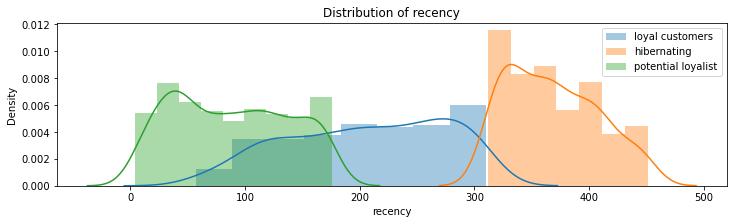

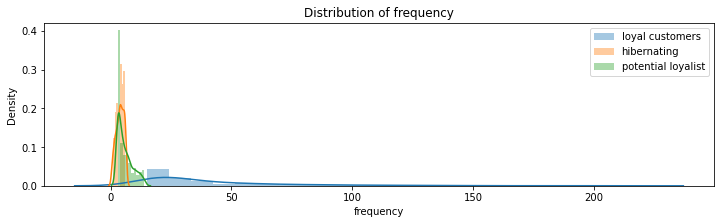

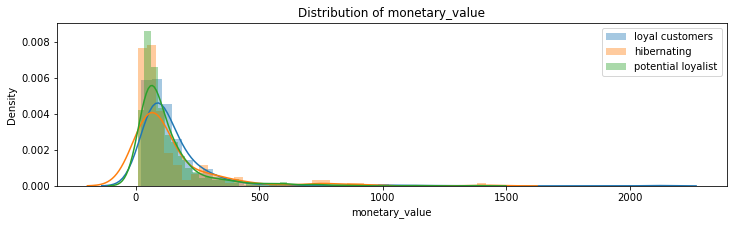

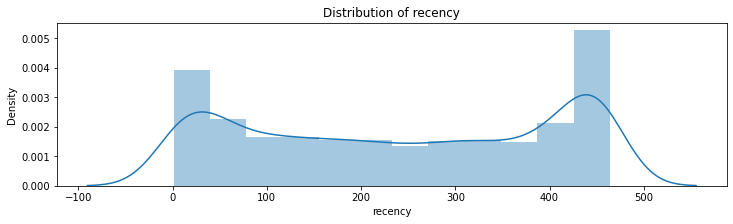

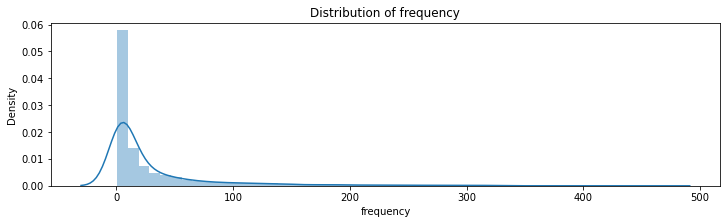

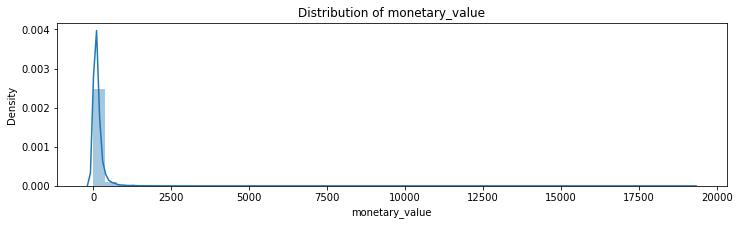

In [51]:
colnames = ['recency', 'frequency', 'monetary_value']
segments = ['loyal customers', 'hibernating', 'potential loyalist']

for col in colnames:
    fig, ax = plt.subplots(figsize=(12,3))
    for segment in segments:
        sns.distplot(returning_customers_summary1[returning_customers_summary1['rfm_label']==segment][col], label=segment)
    ax.set_title('Distribution of %s' % col)
    plt.legend()
    plt.show()
    
for col in colnames:
    fig, ax = plt.subplots(figsize=(12,3))
    sns.distplot(returning_customers_summary1[col])
    ax.set_title('Distribution of %s' % col)
    plt.show()
    

Analysis of clusters obtained by summing up RFM scores shows that their sizes are quite similar. There is a peak around score = 7 which shows that the group of customers from segments 6-8 is numerous - those are the customers that are in limbo. The smallest segment is for RFM score = 14 - it's understandable cause those are the most valuable gems in the customer base. Although it's the smallest group, it is still quite big in size.

Analysis of clusters based on set of rules applied to R-F-M scores is much more diverse. Its interesting to see hibernating, loyal customers and potential loyalist are groupped up around between 0 and 420 monetary value also hibernating organizations are very dense 

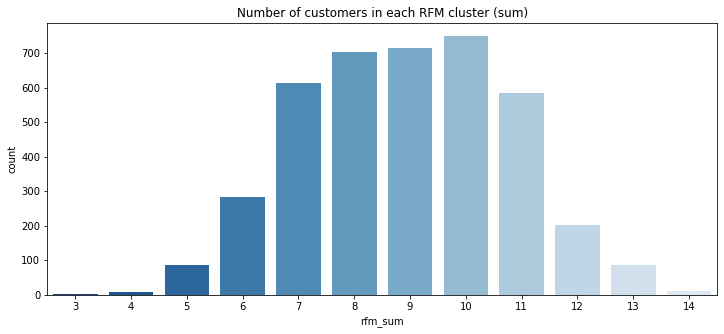

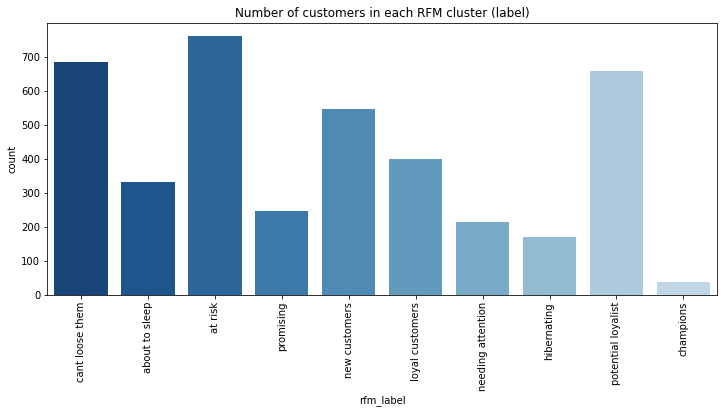

In [52]:
palette = sns.color_palette("Blues_r", n_colors=13)

for rfm_type in ['sum', 'label']:
    fig, ax = plt.subplots(figsize=(12,5))
    sns.countplot(x='rfm_'+rfm_type, data=returning_customers_summary1, palette=palette)
    ax.set_title('Number of customers in each RFM cluster (%s)' % rfm_type)
    if rfm_type == 'label':
        plt.xticks(rotation=90)
    plt.show()

In [53]:
returning_customers_summary1 = returning_customers_summary1.reset_index()

In [54]:
agg_dict2 = {
    'orders_organization_id': 'count',
    'recency': 'mean',
    'frequency': 'mean',
    'monetary_value': 'sum'
}

df_analysis = returning_customers_summary1.groupby('rfm_label').agg(agg_dict2).sort_values(by='recency').reset_index()
df_analysis.rename({'rfm_label': 'label', 'orders_organization_id': 'count'}, axis=1, inplace=True)
df_analysis['count_share'] = df_analysis['count'] / df_analysis['count'].sum()
df_analysis['monetary_share'] = df_analysis['monetary_value'] / df_analysis['monetary_value'].sum()
df_analysis['monetary'] = df_analysis['monetary_value'] / df_analysis['count']

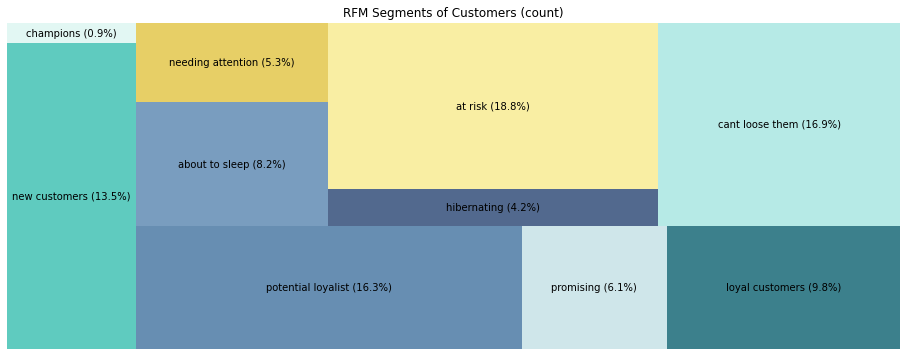

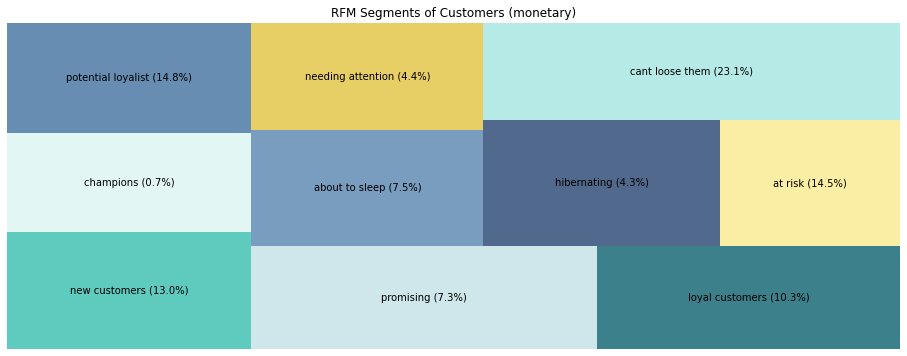

In [55]:
import squarify

colors = ['#37BEB0', '#DBF5F0', '#41729F', '#C3E0E5', '#0C6170', '#5885AF', '#E1C340', '#274472', '#F8EA8C', '#A4E5E0', '#1848A0']

for col in ['count', 'monetary']:
    labels = df_analysis['label'] + df_analysis[col + '_share'].apply(lambda x: ' ({0:.1f}%)'.format(x*100))

    fig, ax = plt.subplots(figsize=(16,6))
    squarify.plot(sizes=df_analysis[col], label=labels, alpha=.8, color=colors)
    ax.set_title('RFM Segments of Customers (%s)' % col)
    plt.axis('off')
    plt.show()